# Role of climate variability of droughts of Lake Poopó between 1989 and 2019 assessed by remote sensing data

##  A timeseries analysis with Google Earth Engine (Python API)

#### Magdalena Halbgewachs (August 2019)

--------------------------------
Lake Poopó, located in the Bolivian Altiplano, is extremely regulated by environmental influences. The basin, which lies at a mean elevation of 3810 m above sea level, is characterized by extreme spatial and temporal fluctuations in water resources and levels. The Desaguadero River transports water from Lake Titicaca to Lake Poopó over 300 km. The lake was declared dry in 2015 but still fills periodically with water. The largest dimensions of the Lake Poopó during the rainy season can be 3,000 km² with a maximum depth of 3.5 meters. In the dry season, there is often no water in the lake, which leads to a superficial salt crust (Calizaya 2009).

-------------------------------------------------------------
The water level depends on several factors. Thereby the climatic conditions play an important role. Due to Bolivia's proximity to the equator, the Inter-Tropical Convergence Zone (ITCZ) contributes to comparatively high precipitation during the summer months. The phases of El Niño Southern Oscillation (ENSO) have a significant impact on the perennial presence of the water resources, depending on whether a year is marked by El Niño or La Niña. Another important factor influencing water availability is the lack of natural regulation due to steep slopes (Revollo 2008). The basin is therefore not a water reservoir and does not ensure access during the dry phase (Calizaya 2009).
However, the strong fluctuations in the lake level can also be attributed to poor land use and water management around the lake. Agriculture and fishery represent a large part of the income of the surrounding population, who are therefore dependent on this water source. At the same time, the limited amount of water gets contaminated by the neighboring mining industry, which leads to conflicts between the private and economic sector (Calizaya 2009). 


----------------------------------
This notebook uses the Google Earth Engine Python API to perform a time series analysis of Lake Poopó.
The intention of this notebook is to calculate the water surface of Lake Poopó for every month for the years 1989 to 2019 using satellite data to compare them with corresponding climatic datasets, like precipitation and evapotranspiration rates. In addition, the water surfaces of Lake Titicaca of the same time frame were added to establish a possible correlation between the water levels of these two lakes, which are connected by the Desaguadero River.

----------------------------------
###### used datasets:


- Monthly average **water levels** of Lake Poopó 1989 to 2019 (Landsat 5 and 8)
- Monthly average **water levels** of Lake Titicaca 1989 to 2019 (Landsat 5 and 8)
- Monthly average **temperatures** around Lake Poopó 1989 to 2019 (TerraClimate, University Idaho)
- monthly average **evapotranspiration** around Lake Poopó 1989 to 2019 (TerraClimate, University Idaho)
- monthly average **water level heights** of Lake Titicaca 2002 to 2017 (DAHITI, Technical University Munich)



----------------------

## Structure

#### A.) Lake Poopó and Lake Titicaca
    1.) Study Area
    2.) Functions
    3.) Load image collections
    4.) Calculations
#### B.) Precipitation around Lake Poopó
    1.) Function
    2.) Load data and image IDs
    3.) Calculations
    4.) Create Dataframe
    5.) Plot
#### C.) Evapotranspiration around Lake Poopó
    1.) Function
    2.) Load data and image IDs
    3.) Calculations
    4.) Create Dataframe
    5.) Plot
#### D.) Create one merged dataset
#### E.) Vizualisation
    1.) Line plot
    2.) Correlation plots

--------------------

### settings

In [58]:
from IPython.display import Image
import ee                         # conda prompt: pip install earthengine-api; register in GEE online

ee.Initialize()                   # if this does not work -> conda prompt: earthengine authenticate

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns             # heatmap
import folium                     # overview map

#from ipygee import *             # maps and graphs through GEE



------------------

## A.) Lake Poopó and Lake Titicaca

### 1.)  Study area

The focus of this analysis is on the water loss of Lake Poopó.
At the same time, all necessary calculations are carried out for Lake Titicaca as well, since its water level affects Lake Poopó through its inflow (River Desaguadero).
For the analysis only a small part of Lake Titicaca (southern part close to outflow of River Desagadero) was used because of deep slopes in the other parts of the lake (only slight changes of water loss would be visible on satelliten imagery).

In [176]:
# visualize study area
study_areaT = folium.Map(location = [-17.6, -67.8],
                    tiles = "stamenterrain",
                    zoom_start = 7)

AOIT = folium.vector_layers.Polygon(locations = [
    [-16.653000098461668, -68.37782938232618], [-15.232216128080522, -68.37782938232618], 
    [-15.232216128080522, -70.17958719482618], [-16.653000098461668, -70.17958719482618]], popup = "Lake Titicaca", color="pink")

AOIT_small = folium.vector_layers.Polygon(locations = [
    [-16.625529549049627, -69.11185879627755], [-16.625529549049627, -68.78913540760567],
    [-16.408286846152148, -68.78913540760567], [-16.408286846152148, -69.11185879627755]], color = "purple")

AOI = folium.vector_layers.Polygon(locations = [
    [-19.212254656848415, -66.70271572533284], [-18.416715777782166, -66.70271572533284], 
    [-18.416715777782166, -67.49922451439534], [-19.212254656848415, -67.49922451439534]], popup = "Lake Poopó", color="purple")

Titicaca = study_areaT.add_child(AOIT)
Titicaca_small = Titicaca.add_child(AOIT_small)
Lakes = Titicaca_small.add_child(AOI)
Lakes

#### Lake Poopó

In [24]:
# define point and area within the required scenes for further analysis

area = ee.Geometry.Polygon([[-67.34105788317754,-18.732392624295784],   # study area around Lake Poopó
                            [-67.15978346911504,-18.732392624295784],
                            [-67.15978346911504,-18.597081788693224],
                            [-67.34105788317754,-18.597081788693224],
                            [-67.34105788317754,-18.732392624295784]])

#### Lake Titicaca

only a small extent (next to the outflow into Lake Poopó) was choosen.

In [72]:
# define point within the required scenes for further analysis

area_T = ee.Geometry.Polygon([[-69.11185879627755,-16.625529549049627],  # study area around Lake Titicaca (only most southern part)
                              [-68.78913540760567,-16.625529549049627],
                              [-68.78913540760567,-16.408286846152148],
                              [-69.11185879627755,-16.408286846152148],
                              [-69.11185879627755,-16.625529549049627]])

----------------

### 2.) Functions

Based on the multiband Landsat images, some spectral indices can be calculated to identify the varying water level over the interannual seasonal course. The NDWI (Normalized Difference Water Index) is especially suitable for the quantitative detection of water surfaces. Particularly in the near-infrared wavelengths (NIR), the absorption of water is very strong, whereas vegetation and dry soil reflect highly. In the visible wavelength range, green light most clearly represents the typical reflection of water. The green (~ 0.53 - 0.59 μm) and near-infrared (~ 0.75 – 2.5 μm) band are therefore used to eliminate ground and land vegetation characteristics and to emphasize water areas (McFeeters 1996):
$$NDWI=(GREEN-NIR)/(GREEN+NIR)$$

--------
The NDWI calculations on their own have little significance over the actual water area. A value range that represents the entire water surface must be defined for this purpose. A threshold of 0.1 was considered suitable for this application. Consequently, all pixels with the values higher than 0.1 were given a new value of 1, representing water features, all other pixels were assigned the value 0, meaning no water features.

In [73]:
# clip scene to predefined extent

def clip(image):
    return image.clip(area)

In [74]:
# get image IDs

def get_img_ids(collection):
    ls_id = []
    for f in collection.getInfo()['features']:
        image_id = f['id']
        ls_id.append(image_id)

    return ls_id

In [75]:
# calculate NDWI, NDWI_threshold and water area per image

def get_water_area(image, area, band_nr=['B2', 'B4'], threshold=0.1):
    ndwi = ee.Image(image.normalizedDifference(band_nr).rename('NDWI')) # NDWI
    ndwi_thresh = ee.Image(ndwi.gte(threshold).rename('NDWI_Thresh'))   # binary values (1 = water)

    latlon = ee.Image.pixelLonLat().addBands(ndwi_thresh)
    latlon = latlon.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=area,
        maxPixels=1e8,
        scale=20)
    data = np.array((ee.Array(latlon.get("NDWI_Thresh")).getInfo()))
    sum = data.sum()
    water_area = sum * 30 * 30                                           #30m resolution of Landsat
    date = image.getInfo()['properties']['DATE_ACQUIRED']
    return water_area, date

### 3.) Load image collections (Landsat 5 and 8)

#### Lake Poopó

In [29]:
# load Landsat 5 image collection

L5 = ee.ImageCollection("LANDSAT/LT05/C01/T1")\                   # used image collection
                        .filterDate('1989-01-01', '2019-07-27')\  # ussed time period
                        .filterBounds(area)\                      # predefined area
                        .filter(ee.Filter.lt('CLOUD_COVER', 5))\  # only cloud cover > 5%
                        .map(clip)                                # clip imagery to predefined area
#print(L5.getInfo())

In [30]:
# load Landsat 8 image collection

L8 = ee.ImageCollection("LANDSAT/LC08/C01/T1")\
        .filterDate('1989-01-01', '2019-07-27')\
        .filterBounds(area)\
        .filter(ee.Filter.lt('CLOUD_COVER', 5))\
        .map(clip)

#print(L8.getInfo())

#### Lake Titicaca

In [76]:
# load Landsat 5 image collection

L5_T = ee.ImageCollection("LANDSAT/LT05/C01/T1")\
                        .filterDate('1989-01-01', '2019-07-27')\
                        .filterBounds(area_T)\
                        .filter(ee.Filter.lt('CLOUD_COVER', 5))\
                        .map(clip)
#print(L5_T.getInfo())

In [77]:
# load Landsat 5 image collection

L8_T = ee.ImageCollection("LANDSAT/LC08/C01/T1")\
        .filterDate('1989-01-01', '2019-07-27')\
        .filterBounds(area_T)\
        .filter(ee.Filter.lt('CLOUD_COVER', 5))\
        .map(clip)

#print(L8_T.getInfo())

---------------------------------------------------------------------------

### 4.) Calculations

#### Lake Poopó

In [33]:
# load image IDs

l5_ids = get_img_ids(L5)
l8_ids = get_img_ids(L8)

#l5_ids
#l8_ids

In [34]:
# calculate water areas with Landsat 5

l5_areas = []
l5_dates = []
for img_id in l5_ids:
    image = ee.Image(img_id)
    water_area, date = get_water_area(image, area)
    print("Area for date {} is {}".format(date, water_area))
    l5_areas.append(water_area)                                 # create list with all water area values per image
    l5_dates.append(date)                                       # create list with all image dates

Area for date 1989-04-10 is 644076000
Area for date 1989-05-28 is 641817900
Area for date 1989-06-13 is 641998800
Area for date 1989-06-29 is 642523500
Area for date 1989-07-31 is 642686400
Area for date 1989-08-16 is 642818700
Area for date 1989-09-17 is 641612700
Area for date 1989-11-04 is 640596600
Area for date 1989-12-22 is 635911200
Area for date 1990-04-13 is 625650300
Area for date 1990-04-29 is 621734400
Area for date 1990-05-31 is 619268400
Area for date 1990-07-02 is 623440800
Area for date 1990-09-04 is 619102800
Area for date 1990-09-20 is 616725900
Area for date 1990-11-07 is 613945800
Area for date 1991-02-27 is 606357000
Area for date 1991-03-31 is 609585300
Area for date 1991-04-16 is 603072900
Area for date 1991-05-02 is 597330000
Area for date 1991-05-18 is 592816500
Area for date 1991-06-03 is 589667400
Area for date 1991-06-19 is 588472200
Area for date 1991-07-05 is 592472700
Area for date 1991-07-21 is 592146900
Area for date 1991-08-06 is 589286700
Area for dat

In [35]:
# calculate water areas with Landsat 8

l8_areas = []
l8_dates = []
for img_id in l8_ids:
    image = ee.Image(img_id)
    water_area, date = get_water_area(image, area, band_nr=['B3', 'B5'])
    print("Area for date {} is {}".format(date, water_area))
    l8_areas.append(water_area)
    l8_dates.append(date)

Area for date 2013-04-12 is 322551000
Area for date 2013-04-28 is 299961000
Area for date 2013-05-14 is 286854300
Area for date 2013-05-30 is 294548400
Area for date 2013-06-15 is 286633800
Area for date 2013-07-01 is 304193700
Area for date 2013-07-17 is 287451900
Area for date 2013-08-02 is 289295100
Area for date 2013-08-18 is 277093800
Area for date 2013-09-03 is 282535200
Area for date 2013-09-19 is 265763700
Area for date 2013-11-06 is 231736500
Area for date 2014-03-14 is 44902800
Area for date 2014-03-30 is 242222400
Area for date 2014-05-17 is 235469700
Area for date 2014-06-02 is 233993700
Area for date 2014-07-04 is 235116900
Area for date 2014-07-20 is 228963600
Area for date 2014-08-05 is 233160300
Area for date 2014-08-21 is 228257100
Area for date 2014-09-22 is 218895300
Area for date 2014-10-24 is 193812300
Area for date 2014-11-25 is 154543500
Area for date 2015-05-04 is 216267300
Area for date 2015-05-20 is 213482700
Area for date 2015-06-05 is 213750900
Area for date

In [62]:
# merge all dates and areas of Landsat 5 and 8 together

for elem in l8_areas:
    l5_areas.append(elem)         # one list with all water areas (Landsat 5 and Landsat 8)
for elem in l8_dates:
    l5_dates.append(elem)         # one list with all image dates (Landsat 5 and Landsat 8)
    

In [67]:
# create pandas dataframe

df = pd.DataFrame({"date": pd.DatetimeIndex(l5_dates), "area_Poopo": l5_areas})  # one dataframe wirh columns data and areas
df['year'] = pd.DatetimeIndex(df['date']).year                                   # extract only the year
mean_df = df.groupby('year').mean()                                              # calculate mean area per year
mean_df

#write missing years; https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
#interplate; https://www.geeksforgeeks.org/python-pandas-dataframe-interpolate/

,area_Poopo
year,
1989,6.415602e+08
1990,6.199812e+08
1991,5.858687e+08
1992,4.327075e+08
1993,2.551690e+08
1994,9.975510e+07
1995,6.875514e+07
1996,6.957135e+07
1997,3.057520e+08


In [64]:
#save dataframe as csv
#mean_df.to_csv(r".\01_data\df_Poopo_year.csv", sep=';', encoding='utf-8')

#open csv
mean_df = pd.read_csv(r".\01_data\df_Poopo_year.csv", sep = ";")
mean_df

,year,area_Poopo
0,1989,6.415602e+08
1,1990,6.199812e+08
2,1991,5.858687e+08
3,1992,4.327075e+08
4,1993,2.551690e+08
5,1994,9.975510e+07
6,1995,6.875514e+07
7,1996,6.957135e+07
8,1997,3.057520e+08
9,1998,1.566716e+08


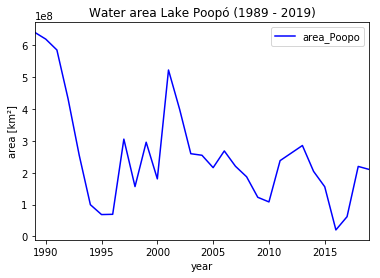

In [157]:
# plot the water area curve of Poopó from 1989 to 2019

mean_df.plot(x = "year", y = "area_Poopo", kind = "line", color="blue")
plt.title("Water area Lake Poopó (1989 - 2019)")
plt.xlabel("year")
plt.ylabel("area [km²]")
plt.legend(loc='best')

#https://www.emilkhatib.com/analyzing-trends-in-data-with-pandas/

There is a **loss in almost every calculated year**, especially 1995 when almost no water was available. Only 1990 was a great profit. These findings also show that the water masses become less with each year and do not regenerate seasonally. Rather, it seems that the lake will become continuously smaller from 2005 onwards. The clear peak in 2001 is related to the La Nina phenomenon, which caused a heavy rainfall and the lake filled up a lot. At the same time, the lake recovers very fast from low to high water levels, for example between 2016 and 2018.

---------------------------------------------------------------------------

#### Lake Titicaca

In [78]:
# load image IDs

l5_T_ids = get_img_ids(L5_T)
l8_T_ids = get_img_ids(L8_T)

#
l5_T_ids.sort()
l8_T_ids.sort()
l5_T_ids
l8_T_ids

['LANDSAT/LC08/C01/T1/LC08_001071_20150831',
 'LANDSAT/LC08/C01/T1/LC08_001071_20160817',
 'LANDSAT/LC08/C01/T1/LC08_001071_20190607',
 'LANDSAT/LC08/C01/T1/LC08_001072_20130505',
 'LANDSAT/LC08/C01/T1/LC08_001072_20130521',
 'LANDSAT/LC08/C01/T1/LC08_001072_20130622',
 'LANDSAT/LC08/C01/T1/LC08_001072_20130724',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140508',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140609',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140625',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140711',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140727',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140812',
 'LANDSAT/LC08/C01/T1/LC08_001072_20140828',
 'LANDSAT/LC08/C01/T1/LC08_001072_20141015',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150511',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150612',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150628',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150714',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150730',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150815',
 'LANDSAT/LC08/C01/T1/LC08_001072_20150831',
 'LANDSAT/

In [79]:
# calculate water areas with Landsat 5

l5_T_areas = []
l5_T_dates = []
for img_id in l5_T_ids:
    image = ee.Image(img_id)
    water_area, date = get_water_area(image, area_T)
    print("Area for date {} is {}".format(date, water_area))
    l5_T_areas.append(water_area)
    l5_T_dates.append(date)

Area for date 1991-07-28 is 887269500
Area for date 1993-05-30 is 873657900
Area for date 1994-06-02 is 906367500
Area for date 1996-05-06 is 875086200
Area for date 1997-08-29 is 883110600
Area for date 1999-08-19 is 834072300
Area for date 2001-08-24 is 938040300
Area for date 2005-09-04 is 890805600
Area for date 2006-07-21 is 891638100
Area for date 2008-08-27 is 883781100
Area for date 2010-08-17 is 887205600
Area for date 1989-05-19 is 732581100
Area for date 1989-08-23 is 825880500
Area for date 1989-09-08 is 820345500
Area for date 1989-12-13 is 819996300
Area for date 1990-06-23 is 819542700
Area for date 1990-07-09 is 798700500
Area for date 1990-07-25 is 809120700
Area for date 1990-08-10 is 683151300
Area for date 1991-02-02 is 817304400
Area for date 1991-04-07 is 833994000
Area for date 1991-04-23 is 853511400
Area for date 1991-05-25 is 817040700
Area for date 1991-06-26 is 821825100
Area for date 1991-07-12 is 807511500
Area for date 1991-07-28 is 787645800
Area for dat

Area for date 1998-09-08 is 853238700
Area for date 1999-05-06 is 243523800
Area for date 1999-05-22 is 891616500
Area for date 1999-06-23 is 883959300
Area for date 1999-07-09 is 850181400
Area for date 1999-09-11 is 864750600
Area for date 2000-07-11 is 682397100
Area for date 2000-08-28 is 689417100
Area for date 2000-09-13 is 676929600
Area for date 2001-05-27 is 899487900
Area for date 2001-07-14 is 755396100
Area for date 2001-07-30 is 804599100
Area for date 2001-11-19 is 899465400
Area for date 2002-03-11 is 649331100
Area for date 2003-06-18 is 914085000
Area for date 2003-07-04 is 900884700
Area for date 2003-07-20 is 847104300
Area for date 2003-08-05 is 890028900
Area for date 2003-08-21 is 898220700
Area for date 2003-10-08 is 894191400
Area for date 2004-02-29 is 904039200
Area for date 2004-05-19 is 882721800
Area for date 2004-06-04 is 911151000
Area for date 2004-06-20 is 908205300
Area for date 2004-07-22 is 902577600
Area for date 2004-11-11 is 891155700
Area for dat

In [80]:
# calculate water areas with Landsat 8

l8_T_areas = []
l8_T_dates = []
for img_id in l8_T_ids:
    image = ee.Image(img_id)
    water_area, date = get_water_area(image, area_T, band_nr=['B3', 'B5'])
    print("Area for date {} is {}".format(date, water_area))
    l8_T_areas.append(water_area)
    l8_T_dates.append(date)

Area for date 2015-08-31 is 793258200
Area for date 2016-08-17 is 775270800
Area for date 2019-06-07 is 269951400
Area for date 2013-05-05 is 473178600
Area for date 2013-05-21 is 303393600
Area for date 2013-06-22 is 146958300
Area for date 2013-07-24 is 231454800
Area for date 2014-05-08 is 582534000
Area for date 2014-06-09 is 250309800
Area for date 2014-06-25 is 243259200
Area for date 2014-07-11 is 282542400
Area for date 2014-07-27 is 281163600
Area for date 2014-08-12 is 810414000
Area for date 2014-08-28 is 557098200
Area for date 2014-10-15 is 830957400
Area for date 2015-05-11 is 468809100
Area for date 2015-06-12 is 255303900
Area for date 2015-06-28 is 234531000
Area for date 2015-07-14 is 263935800
Area for date 2015-07-30 is 429846300
Area for date 2015-08-15 is 719936100
Area for date 2015-08-31 is 795183300
Area for date 2015-09-16 is 828339300
Area for date 2015-11-19 is 824937300
Area for date 2016-01-22 is 808929000
Area for date 2016-04-27 is 825931800
Area for dat

In [81]:
# merge all dates and areas of Landsat 5 and 8 together

for elem in l8_T_areas:
    l5_T_areas.append(elem)
for elem in l8_T_dates:
    l5_T_dates.append(elem)

In [82]:
# create pandas dataframe

df_T = pd.DataFrame({"date": pd.DatetimeIndex(l5_T_dates), "area_Titicaca": l5_T_areas})
df_T['year'] = pd.DatetimeIndex(df_T['date']).year                       # extract only the year
mean_df_T = df_T.groupby('year').mean()                         # calculate mean area per year

mean_df_T

,area_Titicaca
year,
1989,6.541511e+08
1990,7.736279e+08
1991,6.052254e+08
1992,6.586744e+08
1993,5.399780e+08
1994,6.907289e+08
1995,5.554141e+08
1996,5.125903e+08
1997,6.706838e+08


In [84]:
#save dataframe as csv
#mean_df_T.to_csv(r".\01_data\df_Titicaca_year.csv", sep=';', encoding='utf-8')

#open csv
mean_df_T = pd.read_csv(r".\01_data\df_Titicaca_year.csv", sep = ";")
mean_df_T

,year,area_Titicaca
0,1989,6.541511e+08
1,1990,7.736279e+08
2,1991,6.052254e+08
3,1992,6.586744e+08
4,1993,5.399780e+08
5,1994,6.907289e+08
6,1995,5.554141e+08
7,1996,5.125903e+08
8,1997,6.706838e+08
9,1998,6.164001e+08


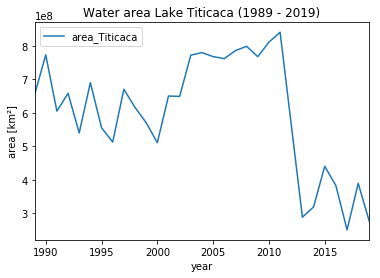

In [158]:
# plot the water area curve of Lake Titicaca from 1989 to 2019

mean_df_T.plot(x = "year", y = "area_Titicaca", kind = "line")
plt.title("Water area Lake Titicaca (1989 - 2019)")
plt.xlabel("year")
plt.ylabel("area [km²]")
plt.legend(loc='best')

The water level of Lake Titicaca has **dropped dramatically after 2010** due to an El Nino phenomenon. The part of the lake that is shown could hardly recover.

------------------

## B.) Precipitation around Lake Poopó

One restricting factor is the seasonal limitation of rain availability. Rivers are only carrying water between December and April when 70 percent of the annual precipitation occurs. Even between the years, precipitation fluctuates by up to 50 percent. Furthermore, the region is characterized by very high evaporation rates, up to 1800mm annually, which far exceeds the rainfall rate. In the region around the lake, it rains 370mm on average per year. However, the predominant climate fluctuations also include very high daily temperature changes. The average temperature lies between 8 and 10°C. Despite the semiarid and cold climate, temperatures can vary by up to 29°C per day. Based on these facts, it is important to connect the calculated water areas with corresponding precipitation and evapotranspiration rates (Calizaya 2009).

### 1.) Function

In [86]:
# extract precipitation data

def get_prec(image):
    prec_img = image.select("pr").rename('precipitation')               # "pr": used band name of image collection
    latlon = ee.Image.pixelLonLat().addBands(prec_img)
    latlon = latlon.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=area,
        maxPixels=1e8,
        scale=20)
    data = np.array((ee.Array(latlon.get("precipitation")).getInfo()))
    mean = data.mean()
    return mean

----------------------

### 2.) Load data and image IDs

the datasets got splitted into four parts, because of GEE runtime limitations

In [87]:
# load precipitation data from 1989 to 1996

PREC_1996 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('1989-01-01', '1996-12-31')\
                        .filterBounds(area)\
                        .select("pr")\
                        .map(clip)
#print(PREC.getInfo())

In [88]:
# load precipitation data 1997 to 2006

PREC_2006 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('1997-01-01', '2006-12-31')\
                        .filterBounds(area)\
                        .select("pr")\
                        .map(clip)

In [89]:
# load precipitation data 2007 to 2016

PREC_2016 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('2007-01-01', '2016-12-31')\
                        .filterBounds(area)\
                        .select("pr")\
                        .map(clip)

In [90]:
# load precipitation data 2017 to 2019

PREC_2019 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('2017-01-01', '2019-07-27')\
                        .filterBounds(area)\
                        .select("pr")\
                        .map(clip)

In [91]:
# load image IDs

PREC_ids_1996 = get_img_ids(PREC_1996)
PREC_ids_2006 = get_img_ids(PREC_2006)
PREC_ids_2016 = get_img_ids(PREC_2016)
PREC_ids_2019 = get_img_ids(PREC_2019)

#PREC_ids_1996

________________

 ### 3.) Calculations

In [92]:
# extract precipitation values

precs_1996 = []
dates_1996 = []
for img_id in PREC_ids_1996:
    date_str = img_id.split("/")[2]                      # extractinf the date out of the image name
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    prec = get_prec(image)
    print("Prec for date {} is {}".format(date, prec))
    precs_1996.append(prec)
    dates_1996.append(date)

Prec for date 1989-01-01 00:00:00 is 48.92703516953001
Prec for date 1989-02-01 00:00:00 is 47.51855478647024
Prec for date 1989-03-01 00:00:00 is 31.607399276366618
Prec for date 1989-04-01 00:00:00 is 15.963695926567928
Prec for date 1989-05-01 00:00:00 is 1.7274529236868186
Prec for date 1989-06-01 00:00:00 is 5.275662464117761
Prec for date 1989-07-01 00:00:00 is 0.6447181212382054
Prec for date 1989-08-01 00:00:00 is 0.925238589744096
Prec for date 1989-09-01 00:00:00 is 6.262958736576653
Prec for date 1989-10-01 00:00:00 is 4.503645148510682
Prec for date 1989-11-01 00:00:00 is 14.394781626714154
Prec for date 1989-12-01 00:00:00 is 20.664256749019778
Prec for date 1990-01-01 00:00:00 is 64.316899563951
Prec for date 1990-02-01 00:00:00 is 41.52511723834757
Prec for date 1990-03-01 00:00:00 is 16.075931490424164
Prec for date 1990-04-01 00:00:00 is 7.392175598892833
Prec for date 1990-05-01 00:00:00 is 9.566133220668696
Prec for date 1990-06-01 00:00:00 is 19.349921095268744
Prec

In [93]:
# extract precipitation values

precs_2006 = []
dates_2006 = []
for img_id in PREC_ids_2006:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    prec = get_prec(image)
    print("Prec for date {} is {}".format(date, prec))
    precs_2006.append(prec)
    dates_2006.append(date)

Prec for date 1997-01-01 00:00:00 is 147.89181562484782
Prec for date 1997-02-01 00:00:00 is 104.57876587472377
Prec for date 1997-03-01 00:00:00 is 41.77549201936884
Prec for date 1997-04-01 00:00:00 is 5.883285490347825
Prec for date 1997-05-01 00:00:00 is 1.0
Prec for date 1997-06-01 00:00:00 is 0.9924161958048217
Prec for date 1997-07-01 00:00:00 is 0.5973884442408759
Prec for date 1997-08-01 00:00:00 is 7.854783706271709
Prec for date 1997-09-01 00:00:00 is 40.29214888052679
Prec for date 1997-10-01 00:00:00 is 1.0
Prec for date 1997-11-01 00:00:00 is 17.267993108504207
Prec for date 1997-12-01 00:00:00 is 29.411868219227483
Prec for date 1998-01-01 00:00:00 is 67.78309161767203
Prec for date 1998-02-01 00:00:00 is 44.621303356116336
Prec for date 1998-03-01 00:00:00 is 15.376752652423013
Prec for date 1998-04-01 00:00:00 is 1.4482775867129434
Prec for date 1998-05-01 00:00:00 is 0.0
Prec for date 1998-06-01 00:00:00 is 4.6690094593545215
Prec for date 1998-07-01 00:00:00 is 1.597

In [97]:
# extract precipitation values

precs_2016 = []
dates_2016 = []
for img_id in PREC_ids_2016:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    prec = get_prec(image)
    print("Prec for date {} is {}".format(date, prec))
    precs_2016.append(prec)
    dates_2016.append(date)

Prec for date 2007-01-01 00:00:00 is 88.94618552548971
Prec for date 2007-02-01 00:00:00 is 54.83858421615816
Prec for date 2007-03-01 00:00:00 is 54.2694237914546
Prec for date 2007-04-01 00:00:00 is 6.392175598892833
Prec for date 2007-05-01 00:00:00 is 3.454905847373637
Prec for date 2007-06-01 00:00:00 is 0.0
Prec for date 2007-07-01 00:00:00 is 1.597388444240876
Prec for date 2007-08-01 00:00:00 is 0.0
Prec for date 2007-09-01 00:00:00 is 7.618202446244095
Prec for date 2007-10-01 00:00:00 is 4.512417459333462
Prec for date 2007-11-01 00:00:00 is 16.376361748249817
Prec for date 2007-12-01 00:00:00 is 25.638062220888497
Prec for date 2008-01-01 00:00:00 is 105.3501685362942
Prec for date 2008-02-01 00:00:00 is 36.03407710420294
Prec for date 2008-03-01 00:00:00 is 31.913120560374953
Prec for date 2008-04-01 00:00:00 is 2.392175598892833
Prec for date 2008-05-01 00:00:00 is 0.0
Prec for date 2008-06-01 00:00:00 is 1.0397458728021511
Prec for date 2008-07-01 00:00:00 is 0.0
Prec for

In [98]:
# extract precipitation values

precs_2019 = []
dates_2019 = []
for img_id in PREC_ids_2019:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    prec = get_prec(image)
    print("Prec for date {} is {}".format(date, prec))
    precs_2019.append(prec)
    dates_2019.append(date)

Prec for date 2017-01-01 00:00:00 is 101.3916004301262
Prec for date 2017-02-01 00:00:00 is 85.82610160612917
Prec for date 2017-03-01 00:00:00 is 71.39527650876508
Prec for date 2017-04-01 00:00:00 is 7.39992787357343
Prec for date 2017-05-01 00:00:00 is 14.369672943508425
Prec for date 2017-06-01 00:00:00 is 2.3619614702735143
Prec for date 2017-07-01 00:00:00 is 4.737083381044701
Prec for date 2017-08-01 00:00:00 is 0.0
Prec for date 2017-09-01 00:00:00 is 23.301346316090115
Prec for date 2017-10-01 00:00:00 is 5.0
Prec for date 2017-11-01 00:00:00 is 18.215796213889075
Prec for date 2017-12-01 00:00:00 is 51.59680801077158
Prec for date 2018-01-01 00:00:00 is 89.77472995365746
Prec for date 2018-02-01 00:00:00 is 143.40153887259024
Prec for date 2018-03-01 00:00:00 is 81.01619685776221
Prec for date 2018-04-01 00:00:00 is 3.007752274680597
Prec for date 2018-05-01 00:00:00 is 3.454905847373637
Prec for date 2018-06-01 00:00:00 is 9.08700184396211
Prec for date 2018-07-01 00:00:00 i

-------------------------

### 4.) Create dataframe

In [99]:
# create pandas dataframe of all precipitation values

df_prec_1996 = pd.DataFrame({"date": pd.DatetimeIndex(dates_1996), "precipitation": precs_1996})
df_prec_1996['year'] = pd.DatetimeIndex(df_prec_1996['date']).year       # extract only the year
df_prec_1996 = df_prec_1996.groupby('year').mean()                       # calculate mean precipitation per year
df_prec_1996

df_prec_2006 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2006), "precipitation": precs_2006})
df_prec_2006['year'] = pd.DatetimeIndex(df_prec_2006['date']).year                       
df_prec_2006 = df_prec_2006.groupby('year').mean()                         
df_prec_2006

df_prec_2016 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2016), "precipitation": precs_2016})
df_prec_2016['year'] = pd.DatetimeIndex(df_prec_2016['date']).year                    
df_prec_2016 = df_prec_2016.groupby('year').mean()                         
df_prec_2016

df_prec_2019 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2019), "precipitation": precs_2019})
df_prec_2019['year'] = pd.DatetimeIndex(df_prec_2019['date']).year                       
df_prec_2019 = df_prec_2019.groupby('year').mean()                         
df_prec_2019

mean_df_prec_all = pd.concat([df_prec_1996, df_prec_2006, df_prec_2016, df_prec_2019])
mean_df_prec_all


,precipitation
year,
1989,16.534617
1990,22.982828
1991,18.457872
1992,20.740207
1993,27.319107
1994,20.467226
1995,15.737210
1996,20.758716
1997,33.212163


In [101]:
#save dataframe as csv
#mean_df_prec_all.to_csv(r".\01_data\df_prec_all.csv", sep=';', encoding='utf-8')

#open csvs
mean_df_prec_all = pd.read_csv(r".\01_data\df_prec_all.csv", sep = ";")
mean_df_prec_all

,year,precipitation
0,1989,16.534617
1,1990,22.982828
2,1991,18.457872
3,1992,20.740207
4,1993,27.319107
5,1994,20.467226
6,1995,15.737210
7,1996,20.758716
8,1997,33.212163
9,1998,15.252422


--------------------------

### 5.) Plot

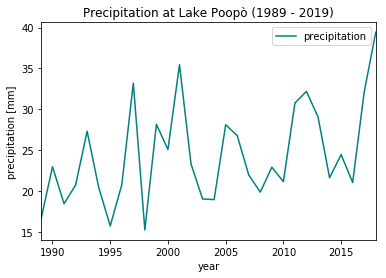

In [153]:
# plot the water area curve of Lake Titicaca from 1989 to 2019

mean_df_prec_all.plot(x = "year", y = "precipitation", kind = "line", color="teal")
plt.title("Precipitation at Lake Poopò (1989 - 2019)")
plt.xlabel("year")
plt.ylabel("precipitation [mm]")
plt.legend(loc='best')

The very strong fluctuations between the years, provide information about the **very high variations of the lake level**, which were previously determined with remote sensing data.

------------------

## C.) Evapotranspiration around lake Poopó

### 1.) Function

In [103]:
# extract evapotranspiration data

def get_et(image):
    et_img = image.select("aet").rename('evapotranspiration')                # "aet": used band
    latlon = ee.Image.pixelLonLat().addBands(et_img)
    latlon = latlon.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=area,
        maxPixels=1e8,
        scale=20)
    data = np.array((ee.Array(latlon.get("evapotranspiration")).getInfo()))
    mean = data.mean()
    return mean

--------------------

### 2.) Load data and image IDs

the datasets got splitted into four parts, because of GEE runtime limitations

In [104]:
# load evapotranspiration data from 1989 to 1996

ET_1996 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('1989-01-01', '1996-12-31')\
                        .filterBounds(area)\
                        .select("aet")\
                        .map(clip)
#print(PREC.getInfo())

In [105]:
# load evapotranspiration data 1997 to 2006

ET_2006 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('1997-01-01', '2006-12-31')\
                        .filterBounds(area)\
                        .select("aet")\
                        .map(clip)

In [106]:
# load evapotranspiration data 2007 to 2016

ET_2016 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('2007-01-01', '2016-12-31')\
                        .filterBounds(area)\
                        .select("aet")\
                        .map(clip)

In [107]:
# load evapotranspiration data 2017 to 2019
ET_2019 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                        .filterDate('2017-01-01', '2019-07-27')\
                        .filterBounds(area)\
                        .select("aet")\
                        .map(clip)

In [108]:
# load image IDs

ET_ids_1996 = get_img_ids(ET_1996)
ET_ids_2006 = get_img_ids(ET_2006)
ET_ids_2016 = get_img_ids(ET_2016)
ET_ids_2019 = get_img_ids(ET_2019)

#ET_ids_1996

---------------------

 ### 3.) Calculations

In [109]:
# extract evapotranspiration values

ets_1996 = []
dates_1996 = []
for img_id in ET_ids_1996:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    et = get_et(image)
    print("ET for date {} is {}".format(date, et))
    ets_1996.append(et)
    dates_1996.append(date)

ET for date 1989-01-01 00:00:00 is 464.8491675846992
ET for date 1989-02-01 00:00:00 is 451.82192274838536
ET for date 1989-03-01 00:00:00 is 300.24354119695647
ET for date 1989-04-01 00:00:00 is 152.19841479802625
ET for date 1989-05-01 00:00:00 is 13.862239841427156
ET for date 1989-06-01 00:00:00 is 48.89160108821404
ET for date 1989-07-01 00:00:00 is 7.199569084086515
ET for date 1989-08-01 00:00:00 is 6.237290678712307
ET for date 1989-09-01 00:00:00 is 61.75684970721672
ET for date 1989-10-01 00:00:00 is 42.57414083342876
ET for date 1989-11-01 00:00:00 is 136.80124168012458
ET for date 1989-12-01 00:00:00 is 196.44934632135482
ET for date 1990-01-01 00:00:00 is 612.1247589753309
ET for date 1990-02-01 00:00:00 is 395.27945041768834
ET for date 1990-03-01 00:00:00 is 152.27245494401646
ET for date 1990-04-01 00:00:00 is 72.54123907409674
ET for date 1990-05-01 00:00:00 is 90.05440806973625
ET for date 1990-06-01 00:00:00 is 183.67604046976942
ET for date 1990-07-01 00:00:00 is 0.

In [110]:
# extract evapotranspiration values

ets_2006 = []
dates_2006 = []
for img_id in ET_ids_2006:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    et = get_et(image)
    print("ET for date {} is {}".format(date, et))
    ets_2006.append(et)
    dates_2006.append(date)

ET for date 1997-01-01 00:00:00 is 1077.456533956674
ET for date 1997-02-01 00:00:00 is 993.9468515103774
ET for date 1997-03-01 00:00:00 is 514.8740090842444
ET for date 1997-04-01 00:00:00 is 108.00367344628754
ET for date 1997-05-01 00:00:00 is 41.87374321675966
ET for date 1997-06-01 00:00:00 is 26.67728820430205
ET for date 1997-07-01 00:00:00 is 20.589032044928974
ET for date 1997-08-01 00:00:00 is 87.17193202742384
ET for date 1997-09-01 00:00:00 is 391.0681976422029
ET for date 1997-10-01 00:00:00 is 18.256272564186595
ET for date 1997-11-01 00:00:00 is 171.1892423698006
ET for date 1997-12-01 00:00:00 is 284.86792835266135
ET for date 1998-01-01 00:00:00 is 648.3893366079784
ET for date 1998-02-01 00:00:00 is 427.47603836388834
ET for date 1998-03-01 00:00:00 is 149.4738442990509
ET for date 1998-04-01 00:00:00 is 17.75566120058912
ET for date 1998-05-01 00:00:00 is 2.497522299306244
ET for date 1998-06-01 00:00:00 is 46.82739145828315
ET for date 1998-07-01 00:00:00 is 19.179

In [111]:
# extract evapotranspiration values

ets_2016 = []
dates_2016 = []
for img_id in ET_ids_2016:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    et = get_et(image)
    print("ET for date {} is {}".format(date, et))
    ets_2016.append(et)
    dates_2016.append(date)

ET for date 2007-01-01 00:00:00 is 848.4127592701543
ET for date 2007-02-01 00:00:00 is 522.063837152217
ET for date 2007-03-01 00:00:00 is 517.9852075016748
ET for date 2007-04-01 00:00:00 is 62.77795590021809
ET for date 2007-05-01 00:00:00 is 34.87947252943956
ET for date 2007-06-01 00:00:00 is 1.6156938154221567
ET for date 2007-07-01 00:00:00 is 19.217124235137415
ET for date 2007-08-01 00:00:00 is 3.9262888979266286
ET for date 2007-09-01 00:00:00 is 73.9577981434026
ET for date 2007-10-01 00:00:00 is 43.760461293247886
ET for date 2007-11-01 00:00:00 is 156.6569717167011
ET for date 2007-12-01 00:00:00 is 243.40695625163698
ET for date 2008-01-01 00:00:00 is 995.9663085352676
ET for date 2008-02-01 00:00:00 is 343.7361331022129
ET for date 2008-03-01 00:00:00 is 303.41572198158144
ET for date 2008-04-01 00:00:00 is 24.986505250882825
ET for date 2008-05-01 00:00:00 is 1.6986786912475633
ET for date 2008-06-01 00:00:00 is 10.232344490554466
ET for date 2008-07-01 00:00:00 is 1.24

In [112]:
# extract evapotranspiration values

ets_2019 = []
dates_2019 = []
for img_id in ET_ids_2019:
    date_str = img_id.split("/")[2]
    date = datetime.datetime.strptime(date_str, '%Y%m')
    image = ee.Image(img_id)
    et = get_et(image)
    print("ET for date {} is {}".format(date, et))
    ets_2019.append(et)
    dates_2019.append(date)

ET for date 2017-01-01 00:00:00 is 963.6446220404144
ET for date 2017-02-01 00:00:00 is 817.4794788470828
ET for date 2017-03-01 00:00:00 is 678.4519773565138
ET for date 2017-04-01 00:00:00 is 71.39504881037462
ET for date 2017-05-01 00:00:00 is 137.5637759500485
ET for date 2017-06-01 00:00:00 is 23.46715812666085
ET for date 2017-07-01 00:00:00 is 44.16974717581606
ET for date 2017-08-01 00:00:00 is 3.239295214253656
ET for date 2017-09-01 00:00:00 is 222.16236737884932
ET for date 2017-10-01 00:00:00 is 48.50734360213589
ET for date 2017-11-01 00:00:00 is 171.18362888057942
ET for date 2017-12-01 00:00:00 is 489.9927939382213
ET for date 2018-01-01 00:00:00 is 853.8833131300369
ET for date 2018-02-01 00:00:00 is 820.934955914696
ET for date 2018-03-01 00:00:00 is 932.687084499794
ET for date 2018-04-01 00:00:00 is 183.17667025982624
ET for date 2018-05-01 00:00:00 is 93.24485737262381
ET for date 2018-06-01 00:00:00 is 120.957942922726
ET for date 2018-07-01 00:00:00 is 91.13364974

------------------

### 4.) Create dataframe

In [113]:
# create pandas dataframe of all evapotranspiration values

df_et_1996 = pd.DataFrame({"date": pd.DatetimeIndex(dates_1996), "evapotranspiration": ets_1996})
df_et_1996['year'] = pd.DatetimeIndex(df_et_1996['date']).year         # extract only the year
df_et_1996 = df_et_1996.groupby('year').mean()                         # calculate mean evapotranspiration per year
df_et_1996

df_et_2006 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2006), "evapotranspiration": ets_2006})
df_et_2006['year'] = pd.DatetimeIndex(df_et_2006['date']).year                     
df_et_2006 = df_et_2006.groupby('year').mean()                         
df_et_2006

df_et_2016 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2016), "evapotranspiration": ets_2016})
df_et_2016['year'] = pd.DatetimeIndex(df_et_2016['date']).year                     
df_et_2016 = df_et_2016.groupby('year').mean()                         
df_et_2016

df_et_2019 = pd.DataFrame({"date": pd.DatetimeIndex(dates_2019), "evapotranspiration": ets_2019})
df_et_2019['year'] = pd.DatetimeIndex(df_et_2019['date']).year                       
df_et_2019 = df_et_2019.groupby('year').mean()                         
df_et_2019

mean_df_et_all = pd.concat([df_et_1996, df_et_2006, df_et_2016, df_et_2019])
mean_df_et_all

,evapotranspiration
year,
1989,156.907110
1990,218.761519
1991,176.109019
1992,196.957707
1993,258.688191
1994,194.476465
1995,149.776680
1996,197.513029
1997,311.331225


In [115]:
#save dataframe as csv
mean_df_et_all.to_csv(r".\01_data\df_et_all.csv", sep=';', encoding='utf-8')

#open csvs
mean_df_et_all = pd.read_csv(r".\01_data\df_et_all.csv", sep = ";")
mean_df_et_all

,year,evapotranspiration
0,1989,156.907110
1,1990,218.761519
2,1991,176.109019
3,1992,196.957707
4,1993,258.688191
5,1994,194.476465
6,1995,149.776680
7,1996,197.513029
8,1997,311.331225
9,1998,147.539175


------------------

### 5.) Plot

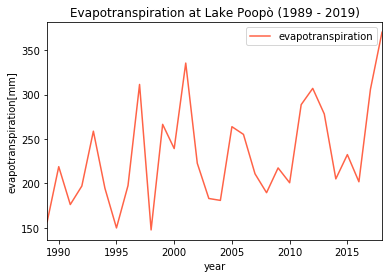

In [152]:
# plot the evapotranspiration curve of Lake Poopó from 1989 to 2019

mean_df_et_all.plot(x = "year", y = "evapotranspiration", kind = "line", color="tomato")
plt.title("Evapotranspiration at Lake Poopò (1989 - 2019)")
plt.xlabel("year")
plt.ylabel("evapotranspiration[mm]")
plt.legend(loc='best')

Due to the **local high solar radiation** of an average of 6.3 kWh/km²/day (twice as high as in Germany), which reaches the lake due to the high location, the **shallow water heats up quickly and evaporates very fast** (Ormachea et al. 2013).

------------------

## D.) Create one merged dataset

In [118]:
# merge all dataframes on "year"
#https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

df_all = (pd.merge(mean_df_et_all, mean_df_prec_all, on='year', how='outer')  # evapotranspiration + precipitation
        .fillna(np.nan)
        .sort_values('year')
        .set_index('year'))
df_all

df_all = (pd.merge(df_all, mean_df, on='year', how='outer')                   # mean_df (area Poopó)
        .fillna(np.nan)
        .sort_values('year')
        .set_index('year'))
df_all

df_all = (pd.merge(df_all, mean_df_T, on='year', how='outer')                 # mean_df_T (area Titicaca)
        .fillna(np.nan)
        .sort_values('year')
        .set_index('year'))
df_all
df_all= df_all.interpolate()   # interpolate missing values

#save as csv
#df_all.to_csv(r".\01_data\df_all.csv", sep=';', encoding='utf-8')

-------------------

## E.) Visualisation

In [119]:
#open the complete merged dataset

df_all = pd.read_csv(r".\01_data\df_all.csv", sep=';', encoding='utf-8')
df_all

,year,evapotranspiration,precipitation,area_Poopo,area_Titicaca
0,1989,156.907110,16.534617,6.415602e+08,6.541511e+08
1,1990,218.761519,22.982828,6.199812e+08,7.736279e+08
2,1991,176.109019,18.457872,5.858687e+08,6.052254e+08
3,1992,196.957707,20.740207,4.327075e+08,6.586744e+08
4,1993,258.688191,27.319107,2.551690e+08,5.399780e+08
5,1994,194.476465,20.467226,9.975510e+07,6.907289e+08
6,1995,149.776680,15.737210,6.875514e+07,5.554141e+08
7,1996,197.513029,20.758716,6.957135e+07,5.125903e+08
8,1997,311.331225,33.212163,3.057520e+08,6.706838e+08
9,1998,147.539175,15.252422,1.566716e+08,6.164001e+08


### 1.) Line plot

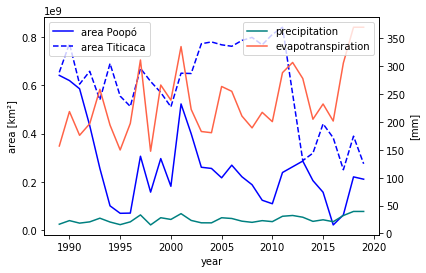

In [120]:
#plots
#https://stackoverflow.com/questions/45155510/plotting-mulitple-lines-on-two-y-axis-using-matplotlib
#%matplotlib qt
%matplotlib inline

df_all.set_index("year",drop=True,inplace=True)                             # use the actual years as index for x axis (execute red_csv first)

#first y axis
fig, ax = plt.subplots()
plt.plot(df_all['area_Poopo'], 'blue', label='area Poopó')
plt.plot(df_all['area_Titicaca'], '--b', label='area Titicaca')
plt.legend(loc='upper left')
plt.ylabel("area [km²]")
plt.xlabel("year")
ax.tick_params('vals', colors='r')

# second y axis
ax2 = ax.twinx()
plt.plot(df_all['precipitation'], 'teal', label='precipitation')
plt.plot(df_all['evapotranspiration'], 'tomato', label='evapotranspiration')
plt.legend(loc='upper right')
plt.ylabel("[mm]")
ax.tick_params('vals', colors='b')

**Evaporation (red)**: The peaks of the evaporation always correspond to those of the water surface (blue). The more water the lake contains, the more evaporation takes place.

**Area Titicaca (dashed blue)**: with decreasing water masses of Lake Titicaca, the water level in Lake Poopó also drops (especially in the perod after 2011).

**Precipitation (green)**: The almost consistent curve of precipitation is very noticeable. The evaporation is at all times more than twice as high as the existing rain, which in turn favours the drying out of the lake.

These findings show, on the one hand, a **slight decrease in rainfall between 1989 and 2018** and, on the other hand, an **increase in evaporation rates**. This means that less water feeds the lake, which in turn evaporates faster. The problem is that Lake Poopó is very shallow (3.5 meters maximum) and the little water available in this area heats up rapidly due to the strong solar radiation, thus promoting evaporation, as stated previously.
The strong fluctuations in precipitation and evaporation can partly be attributed to the **ENSO (El Niño-Southern Oscillation) effect**. It is the most important factor to explain the interannual fluctuations of rainfall in the Bolivian Altiplano.

### 2.) Correlation plot

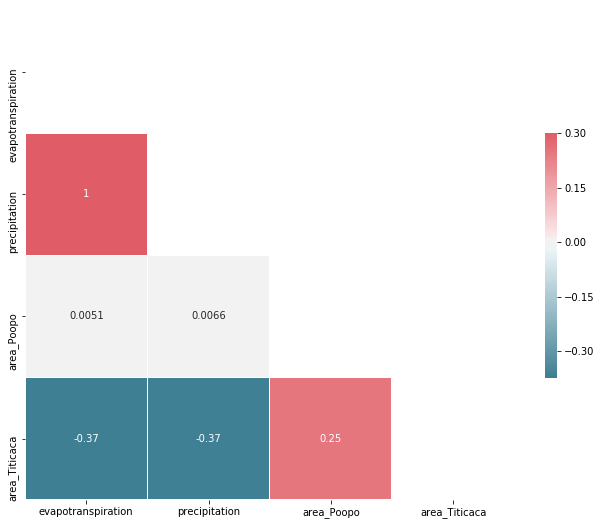

In [121]:
# Compute the correlation matrix
%matplotlib inline

corr = df_all.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Due to the fact that **Lake Titicaca has very steeply sloping walls** and fluctuations of the water level are not visible via satellite images, the correlation between the water levels of the two lakes is not significant high. In the following a data set about the water levels (height of the water) of Lake Titicaca is imported and compared with the previous data.

--------------------------

With the help of a DAHITI (Database for Hydrological Time Series of Inland Waters) dataset a **water level time series of Lake Titicaca** could be established from 2002 to 2017, which will be used in the following.

In [165]:
# load water level heights of Lake Titicaca 
Titicaca = pd.read_csv(r".\01_data\time_series_titicaca.csv", sep=";", encoding='utf-8')
Titicaca = Titicaca.rename(columns={"heights": "height_Titicaca"})

# delete unrelevant columns
Titicaca = Titicaca.drop("Unnamed: 0", axis=1)

# calculate mean height per year
Titicaca['year'] = pd.DatetimeIndex(Titicaca['date']).year         
Titicaca = Titicaca.groupby('year').mean()                         
Titicaca

#Titicaca.to_csv(r'.\01_data\time_series_titicaca2.csv', sep=';', encoding='utf-8')

,height_Titicaca
year,
2002,3810.651400
2003,3811.164545
2004,3811.107250
2005,3810.607158
2006,3810.582789
2007,3810.350400
2008,3810.160474
2009,3809.549450
2010,3809.557750


In [170]:
#reload the data to avoid errors with column "year"

Titicaca = pd.read_csv(r'.\01_data\time_series_titicaca2.csv', sep=";", encoding='utf-8')
#Titicaca

In [174]:
#create one dataset

df_all_T = df_all.drop("area_Titicaca", axis=1)                   # delete column "area_Titicaca"
df_all_T = (pd.merge(df_all, Titicaca, on='year', how='outer')
        .fillna(np.nan)
        .sort_values('year')
        .set_index('year'))
df_all_T= df_all_T.interpolate()                                  # interpolate missing values
df_all_T

#save as csv
df_all_T.to_csv(r".\01_data\df_all_T.csv", sep=';', encoding='utf-8')

#open the complete merged dataset
df_all_T = pd.read_csv(r".\01_data\df_all_T.csv", sep=';', encoding='utf-8')
df_all_T

,year,evapotranspiration,precipitation,area_Poopo,area_Titicaca,height_Titicaca
0,1989,156.907110,16.534617,6.415602e+08,6.541511e+08,NaN
1,1990,218.761519,22.982828,6.199812e+08,7.736279e+08,NaN
2,1991,176.109019,18.457872,5.858687e+08,6.052254e+08,NaN
3,1992,196.957707,20.740207,4.327075e+08,6.586744e+08,NaN
4,1993,258.688191,27.319107,2.551690e+08,5.399780e+08,NaN
5,1994,194.476465,20.467226,9.975510e+07,6.907289e+08,NaN
6,1995,149.776680,15.737210,6.875514e+07,5.554141e+08,NaN
7,1996,197.513029,20.758716,6.957135e+07,5.125903e+08,NaN
8,1997,311.331225,33.212163,3.057520e+08,6.706838e+08,NaN
9,1998,147.539175,15.252422,1.566716e+08,6.164001e+08,NaN


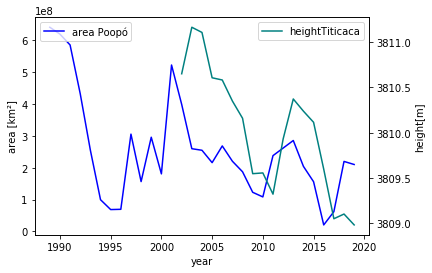

In [175]:
#plots
#%matplotlib qt
%matplotlib inline

df_all_T.set_index("year",drop=True,inplace=True)                             # use the actual years as index for x axis (execute read_csv every time)

fig, ax = plt.subplots()
plt.plot(df_all_T['area_Poopo'], 'blue', label='area Poopó')
#plt.plot(df_all_T['area_Titicaca'], '--b', label='area Titicaca')
plt.legend(loc='upper left')
plt.ylabel("area [km²]")
plt.xlabel("year")
ax.tick_params('vals', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(df_all_T['height_Titicaca'], 'teal', label='heightTiticaca')
plt.legend(loc='upper right')
plt.ylabel("height[m]")
ax.tick_params('vals', colors='b')

This dataset shows now the high dependence of the water level of Lake Poopó on that of Lake Titicaca very clearly.

During 2002 and 2018 the lake level fluctuated by 2.96 meters, which corresponds to a loss of about 24,000km³ at an original total area of 8,200km² (Calizaya 2009; Schwatke et al. 2015). This decreasing trend leads to less water availability in the tributary of the river and thus in Lake Poopó. These keytaches correlate very strongly with the water level of Lake Poopó. 

In [137]:
corr = df_all_T.corr()
corr

,evapotranspiration,precipitation,area_Poopo,area_Titicaca,height_Titicaca
evapotranspiration,1.000000,0.999728,0.005116,-0.372273,-0.641448
precipitation,0.999728,1.000000,0.006593,-0.366051,-0.645431
area_Poopo,0.005116,0.006593,1.000000,0.252460,0.551796
area_Titicaca,-0.372273,-0.366051,0.252460,1.000000,0.441704
height_Titicaca,-0.641448,-0.645431,0.551796,0.441704,1.000000


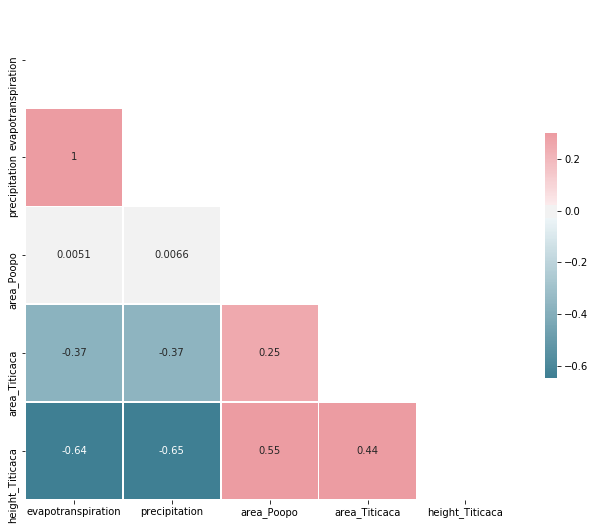

In [138]:
# Compute the correlation matrix
%matplotlib inline

df_all_T = df_all_T.loc[:,['evapotranspiration', 'precipitation','area_Poopo', 'area_Titicaca', 'height_Titicaca']]  # use on ly these mentioned columns

corr = df_all_T.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlation plot including the water level of Lake Titicaca clearly shows a higher correlation of 0.55.

**FAZIT**: The calculations indicate **strong seasonal fluctuations**. The blending with environmental data revealed a clear correlation between the decreasing water availability and the reduction of the water surface of Lake Poopó. Based on the analyses, precipitation plays a rather subordinate role. Much more decisive is evapotranspiration. Due to the high exposure of the lake, the solar radiation is very high and water evaporates quickly. Especially the years 1998 and 2015 have to be emphasized. In these two years, the El Niño phenomenon occurred strongly. This in turn adversely affected precipitation in the region. But not only small-scale research is involved. The declining water level of Lake Titicaca is even more important and correlates with the state of Lake Poopó, which is fed by the connecting river Desaguadero.

**CONCLUSION**: Global warming increases the risk that Lake Poopó will be fed by even less water in the future. This has a significant impact on the ecosystem services offered by water surfaces until now. Freshwater ecosystem services provide a lot of benefits for the living environment. If Lake Poopó continues to shrink, these services can no longer be provided. This has a particular impact on the local flora and fauna and the population (Calizaya 2009). For the inhabitants, this actually means that agriculture or fishing is no longer possible due to water shortage and that the population is forced to resettle in order to escape unemployment and poverty (Martínez et al. 2017).
In combination with ENSO forecasts, this information and climatological correlations can help to estimate the lake level and take measures to ensure that serious fluctuations in the Poopó level are detected at an early stage and do not occur unexpectedly for the local population.

-------------

###### References
1.	Calizaya, A. (2009): Water Resources Management efforts for best water allocation in the Lake Poopo basin, Bolivia.
2.	McFeeters, S. K. (1996): The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features. In: International Journal of Remote Sensing, 17(7), 1425-1432.
3.	Ormachea, O., Abrahamse, A., Tolavi, N., Romero, F., Urquidi Gandarillas, O., Pearce, J., Andrews, R. (2013): Installation of a Variable-angle Spectrometer System for Monitoring Diffuse and Global Solar Radiation.
4.	Revollo, M. (2008): Management issues in the Lake Titicaca and Lake Poopo system: Importance of developing a water budget. In: Lakes & Reservoirs Research & Management, 6(3), 225 – 229.
5.	Schwatke, C., Dettmering, D., Bosch, W., and Seitz, F. (2015): DAHITI - an innovative approach for estimating water level time series over inland waters using multi-mission satellite altimetry. In: Hydrol. Earth Syst. Sci., 19, 4345-4364.

__________________________